In [9]:
import os, glob, shutil
import urllib.request as r
import kaggle

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"


    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass


    else:
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

data_yuklab_olish(saqlash_uchun_papka = "aeroscapes1", data_nomi = "aeroscapes")


aeroscapes dataset yuklanmoqda...
Tanlangan dataset aeroscapes1/aeroscapes papkasiga yuklab olindi!


In [8]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 891.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5e1c1db238e64248a466b4db810230ac3043cdd496dcefac0de7896d8325b45b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8e29c70f85905044efbdf4e4bb37769e7f873e62abc7c5878ad9819b9b495fe6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [10]:
import torch, os, random, cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn import *
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T

In [11]:
def get_transformation(size):
    return [A.Compose([A.Resize(size, size),
                      A.HorizontalFlip(0.5),
                      A.GaussNoise(0.3),
                      A.VerticalFlip(0.5)],is_check_shapes =False),
                     A.Compose([A.Resize(size, size)], is_check_shapes =False )]
tr_trf, ts_trf = get_transformation(size = 320)
tr_trf, ts_trf

(Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.3), per_channel=True, mean=0),
   VerticalFlip(always_apply=0.5, p=0.5),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False),
 Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False))

In [12]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations=None, im_type = [".jpg", ".jpeg", ".png"] ):
        super().__init__()
        self.transformations = transformations
        self.tensorsize = T.Compose([T.ToTensor()])
        self.im_path = sorted(glob(f"{root}/images/*[{i for i in im_type}]"))
        self.labels_path = sorted(glob(f"{root}/labels/*[{i for i in im_type}]"))
        print(len(self.im_path))
        print(len(self.labels_path))


    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):

        im = cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.labels_path[idx]), cv2.COLOR_BGR2GRAY)

        if self.transformations is not None:

             transform = self.transformations(image = im, mask = gt)
             im = transform['image']
             gt =transform["mask"]

        im = self.tensorsize(im)
        gt = torch.tensor(gt>2).long()
        return im, gt

data = "aeroscapes1/aeroscapes/aerospaces"
ds = CustomDataset(root =data, transformations=tr_trf)
im, gt = ds[0]
print(np.unique(gt))
print(type(gt))
print(gt.shape)

3269
3269
[0 1]
<class 'torch.Tensor'>
torch.Size([320, 320])


In [ ]:
# import albumentations as A

# def get_transformations (size):

#     return [A.Compose([A.Resize(size , size),
#                       A.HorizontalFlip(0.5),
#                       A.VerticalFlip(0.5),
#                       A.GaussNoise(0.3)]),
#                       A.Compose([A.Resize(size, size)])]

# tr_ts , ts_ts = get_transformations (size = 320)
# tr_ts , ts_ts

In [ ]:
# def get_dls(root, transformations, bs, split=[0.8, 0.1, 0.1], ns = 0):
#     ds = CustomDataset(root="aeroscapes1/aeroscapes/aerospaces", transformations=transformations)
#     tr_length = len(ds)
#     tr_len = int(tr_length * split[0])
#     val_len = int(tr_length * split[1])
#     ts_len = tr_length - tr_len - val_len

#     print(tr_len)
#     print(val_len)
#     print(ts_len)

#     tr_ds , val_ds , ts_ds = random_split(dataset = ds , lengths = [tr_len , val_len , ts_len])

#     tr_dl = DataLoader(dataset = tr_ds , batch_size = bs , shuffle = True, num_workers = 0)
#     val_dl = DataLoader(dataset = val_ds , batch_size = bs , shuffle = False, num_workers = 0)
#     ts_dl = DataLoader(dataset = ts_ds , batch_size = 1 , shuffle = False, num_workers = 0)

#     return tr_dl , val_dl , ts_dl



# tr_dl, val_dl, ts_dl = get_dls(root="aeroscapes1/aeroscapes/aerospaces", transformations=ts_trf, bs=8)



In [13]:
def get_dlr(root, transformations, bs, split =[0.8, 0.1, 0.1]):
    ds = CustomDataset(root = root, transformations=transformations)
    ds_len = len(ds)

    tr_len =int(split[0]*ds_len)
    val_len =int(split[1]*ds_len)
    ts_len = ds_len-(tr_len+val_len)

    tr_ds, val_ds, ts_ds = random_split(ds,[tr_len, val_len, ts_len])


    print(len(tr_ds))
    print(len(val_ds))
    print(len(ts_ds))

    tr_dl = DataLoader(tr_ds, batch_size =bs, shuffle =True, num_workers =0)
    val_dl = DataLoader(val_ds, batch_size =bs, shuffle =True, num_workers =0)
    ts_dl = DataLoader(ts_ds, batch_size =1, shuffle =False, num_workers =0)
    return tr_dl, val_dl, ts_dl


tr_dl, val_dl, ts_dl = get_dlr(root = "aeroscapes1/aeroscapes/aerospaces", transformations= ts_trf, bs = 64 )

3269
3269
2615
326
328


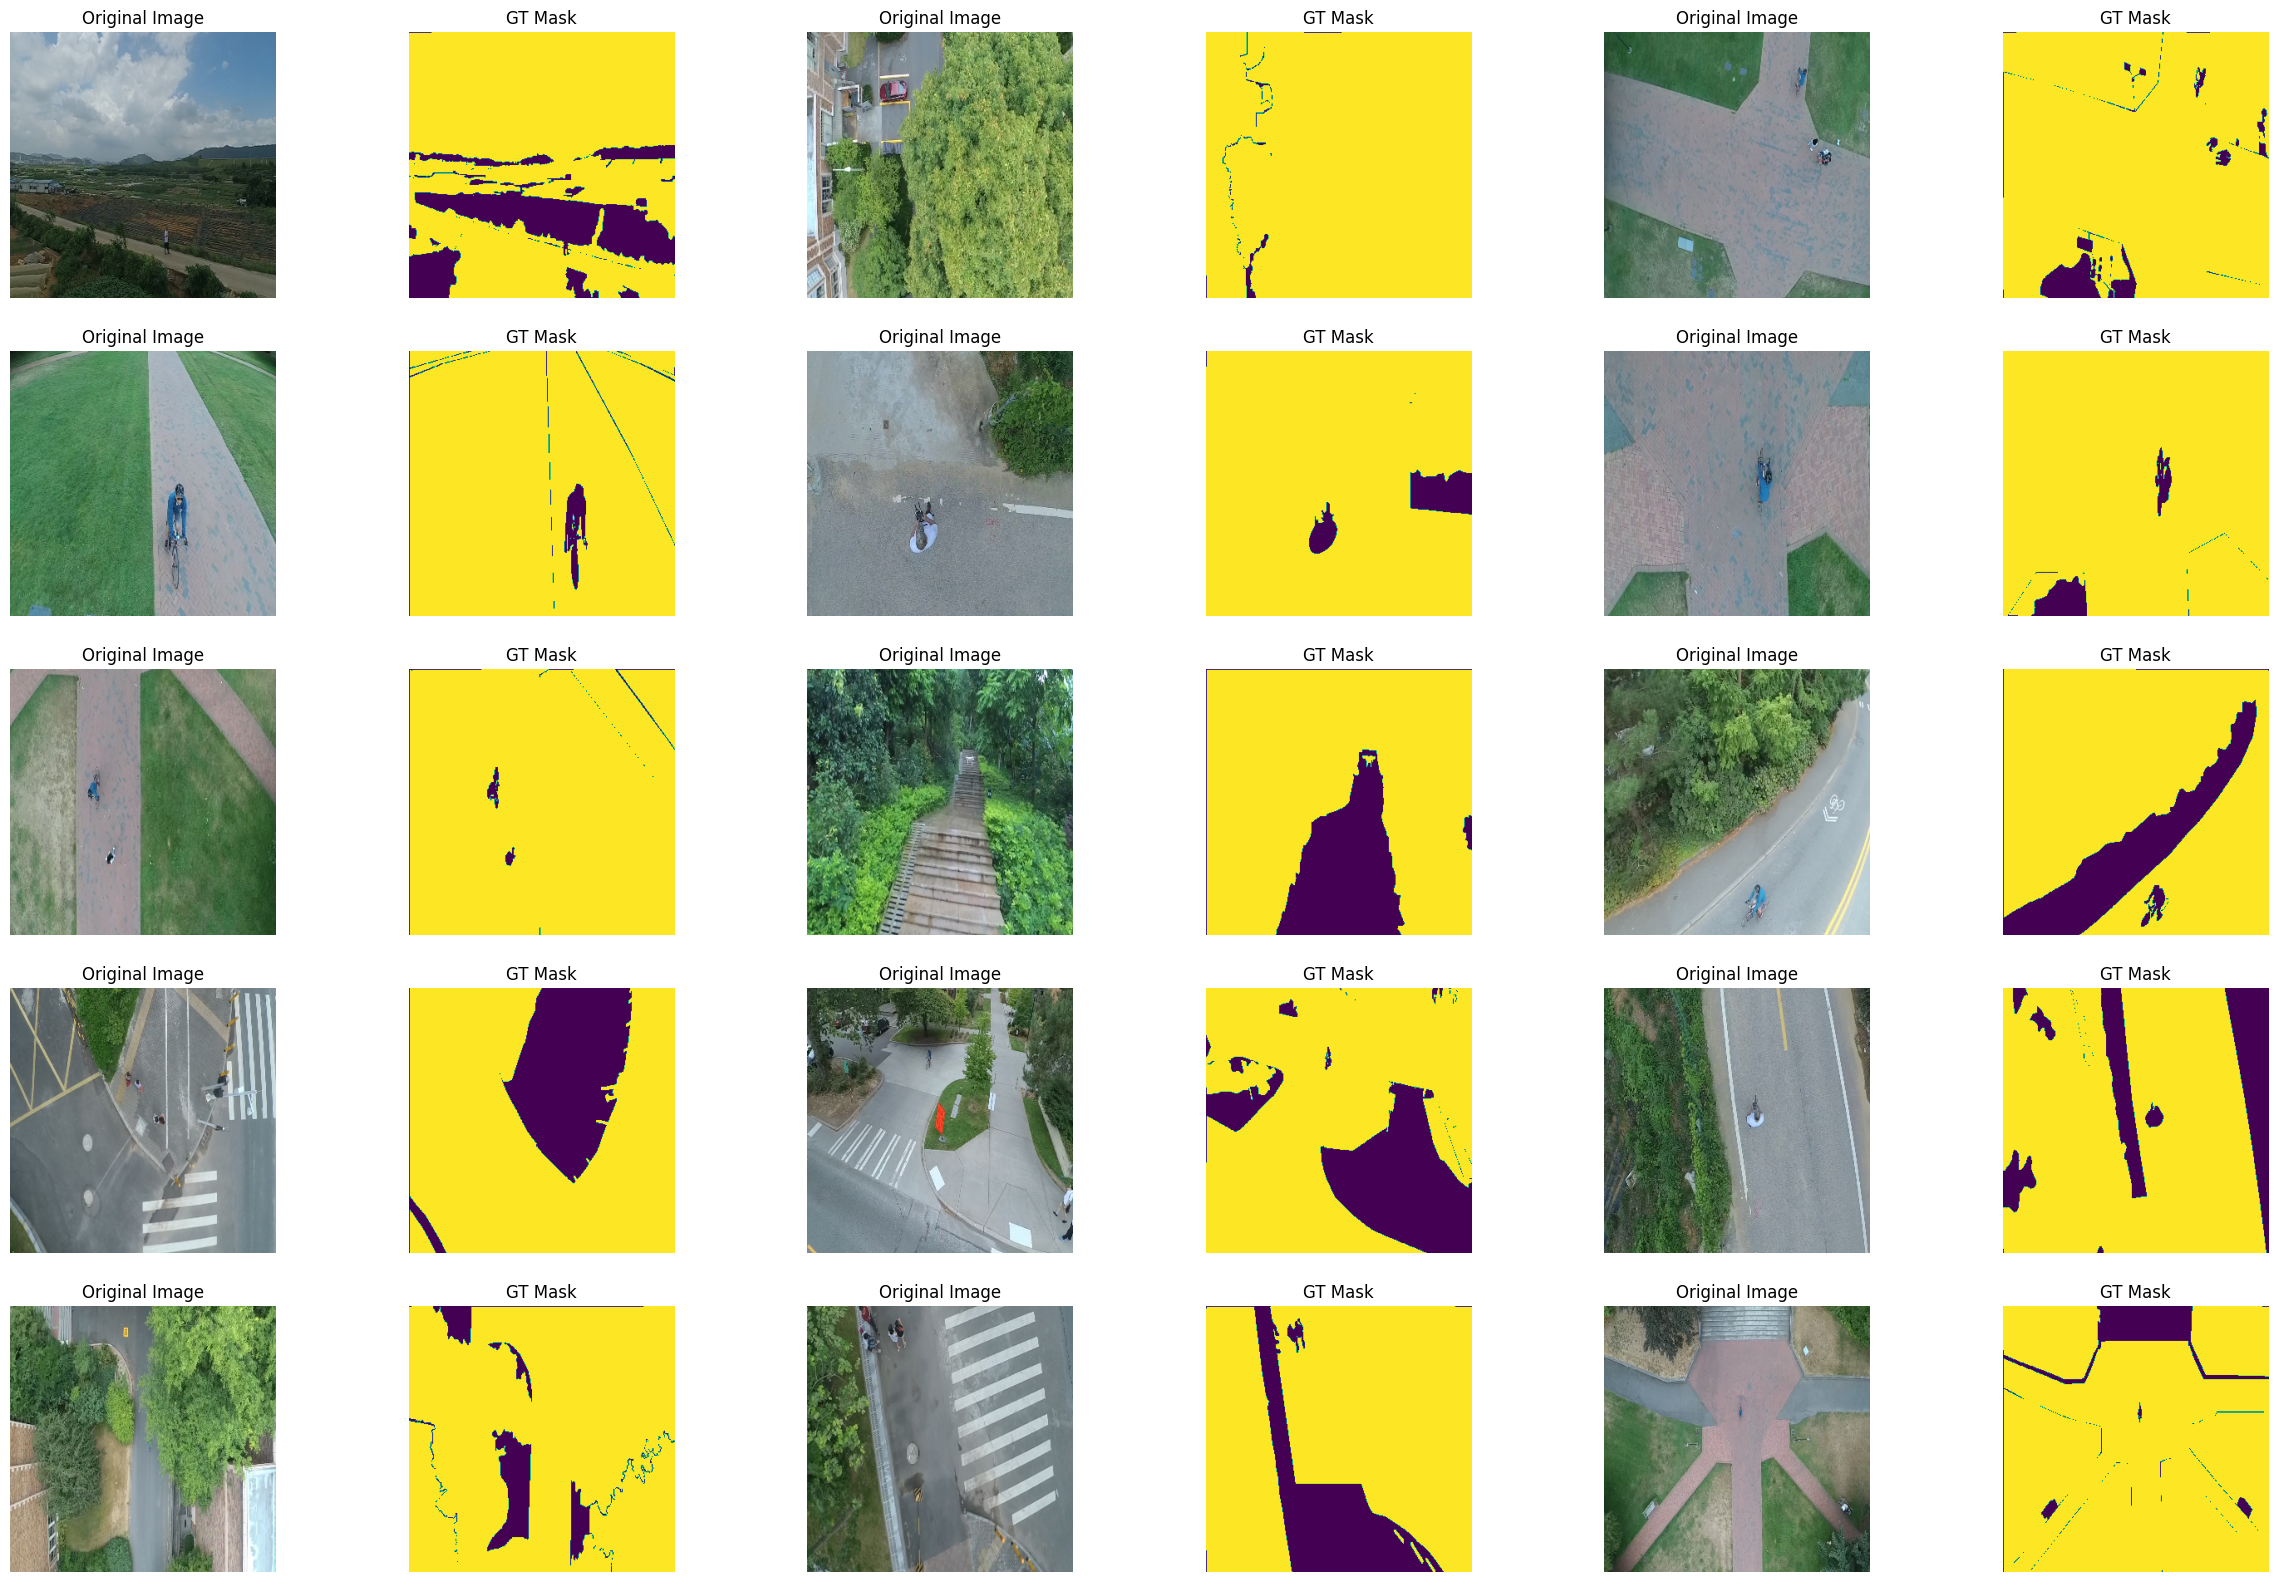

In [14]:
import random

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8"))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (30, 20))
    rows = n_ims // 6; cols = n_ims // rows
    count = 1
    indexs = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indexs):

        if count == n_ims + 1: break

        im, gt = ds[index]


        count = plot(rows, cols, count, im = im)


        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 30)

In [15]:
# import torch
# from torch import nn
# from torch.nn import functional as F

# class UNetBlock(nn.Module):

#     def __init__(self, in_chs, out_chs, ks = 3, p = 1):
#         super().__init__()

#         self.ks, self.p = ks, p

#         self.block_1 = self.get_conv_block(in_chs = in_chs, out_chs = out_chs)
#         self.block_2 = self.get_conv_block(in_chs = out_chs, out_chs = out_chs)


#     def get_conv_block(self, in_chs, out_chs):

#         return nn.Sequential(nn.Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = self.ks, padding = self.p),
#                              nn.BatchNorm2d(num_features = out_chs), nn.ReLU(inplace = True))

#     def forward(self, inp): return self.block_2(self.block_1(inp))

# class DownSampling(nn.Module):

#     def __init__(self, in_chs, out_chs):
#         super().__init__()

#         self.downsample_block = nn.Sequential( nn.MaxPool2d(2), UNetBlock(in_chs = in_chs, out_chs = out_chs))

#     def forward(self, inp): return self.downsample_block(inp)


# class UpSampling(nn.Module):
#     def __init__(self, in_chs, out_chs, mode, upsample = None):
#         super().__init__()

#         if mode in ["bilinear", "nearest"]:
#             upsample = True
#             up_mode = mode

#         self.upsample = nn.Upsample(scale_factor = 2, mode = up_mode) if upsample else nn.ConvTranspose2d(in_channels = in_chs, out_channels = in_chs // 2, kernel_size = 2, stride = 2)
#         self.conv = UNetBlock(in_chs = in_chs, out_chs = out_chs)

#     def forward(self, inp1, inp2):

#         inp1 = self.upsample(inp1)
#         # Padding
#         pad_y = inp2.shape[2] - inp1.shape[2]
#         pad_x = inp2.shape[3] - inp1.shape[3]
#         inp1 = F.pad(inp1, [pad_x // 2, pad_x - pad_x // 2, pad_y // 2, pad_y - pad_y // 2])
#         concat = torch.cat([inp1, inp2], dim = 1)

#         return self.conv(concat)

# class FinalConv(nn.Module):
#     def __init__(self, in_chs, out_chs):
#         super().__init__()

#         self.conv = nn.Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = 1)

#     def forward(self, inp): return self.conv(inp)
# #
# class UNet(nn.Module):

#     def __init__(self, in_chs, n_cls, out_chs, up_method):
#         super().__init__()

#         assert up_method in ["bilinear", "nearest", "tr_conv"], "Please choose a proper method for upsampling!"

#         self.init_block = UNetBlock(in_chs, out_chs, ks = 3, p = 1)

#         factor = 2 if up_method in ["bilinear", "nearest"] else 1

#         # Encoder blocks
#         self.enc_block_1 = DownSampling(out_chs, out_chs * 2)
#         self.enc_block_2 = DownSampling(out_chs * 2, out_chs * 4)
#         self.enc_block_3 = DownSampling(out_chs * 4, out_chs * 8)
#         self.enc_block_4 = DownSampling(out_chs * 8, out_chs * 16 // factor)

#         # Decoder blocks
#         self.dec_block_1 = UpSampling(out_chs * 16, out_chs * 8 // factor, up_method)
#         self.dec_block_2 = UpSampling(out_chs * 8, out_chs * 4 // factor, up_method)
#         self.dec_block_3 = UpSampling(out_chs * 4, out_chs * 2 // factor, up_method)
#         self.dec_block_4 = UpSampling(out_chs * 2, (out_chs // factor) * 2 if up_method in ["bilinear", "nearest"] else (out_chs // factor), up_method)
#         self.final_conv = FinalConv(out_chs, n_cls)

#     def forward(self, inp):

#         init_conv = self.init_block(inp)

#         enc_1 = self.enc_block_1(init_conv)
#         enc_2 = self.enc_block_2(enc_1)
#         enc_3 = self.enc_block_3(enc_2)
#         enc_4 = self.enc_block_4(enc_3)

#         dec_1 = self.dec_block_1(enc_4, enc_3)
#         dec_2 = self.dec_block_2(dec_1, enc_2)
#         dec_3 = self.dec_block_3(dec_2, enc_1)
#         dec_4 = self.dec_block_4(dec_3, init_conv)

#         return self.final_conv(dec_4)


# inp = torch.rand(1,3,224, 224)
# model = UNet(in_chs = 3, n_cls = 2, out_chs = 64, up_method = 'tr_conv')
# # model = UNet(3,2, 64, 'nearest')
# # print(model(inp).shape)
# # print(model)

In [16]:
import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name='resnet18', classes=2, encoder_depth=5,
                 encoder_weights='imagenet', activation=None, decoder_channels=[256,128,64,32,16])
model

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


In [17]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps =3e-4, number_class = 2):

        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim =1)

        self.pred_ = pred
        self.gt = gt
        self.loss_fn = loss_fn
        self.eps = eps
        self.number_class = number_class

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    # PA
    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum())/float(match.numel())

     # mIoU
    def mioU(self):
        pred, gt =self.to_contiguous(self.pred), self.to_contiguous(self.gt)
        Iou_class = []
        for a in range(self.number_class):
            match_pred = pred ==a
            match_gt =gt==a
            if match_gt.long().sum().item()==0: Iou_class.append(np.nan)
            else:
                intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()

                iou = (intersection)/(union+self.eps)
                Iou_class.append(iou)

            return np.nanmean(Iou_class)

    def loss(self):

        return self.loss_fn(self.pred_, self.gt)



In [ ]:
# from tqdm import tqdm
# import time
# import os , numpy as np

# def tic_toc(start_time=None):
#     return time.time() if start_time is None else time.time() - start_time

# def train(tr_dl, val_dl, model, device, loss_fn, epochs, opt, save_prefix):
#     tr_loss, tr_pa, tr_iou = [], [], []
#     val_loss, val_pa, val_iou = [], [], []

#     tr_len, val_len = len(tr_dl), len(val_dl)
#     best_loss = np.inf
#     os.makedirs("modellar", exist_ok=True)
#     model.to(device)
#     train_start = tic_toc()

#     for epoch in range(1, epochs + 1):
#         tic = tic_toc()
#         model.train()
#         tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
#         print(f"{epoch} - epoch train jarayonlari boshlanish arafasida ...")

#         for i, batch in enumerate(tqdm(tr_dl)):
#             # if i == 1:
#             #     break
#             ims, gts = batch
#             ims, gts = ims.to(device), gts.to(device)

#             bashoratlar = model(ims)

#             met = Metrics(gt=gts, pred=bashoratlar, loss_fn=loss_fn, n_cls=2)

#             loss_ = met.loss()
#             tr_loss_ += loss_
#             tr_iou_ += met.mIoU()
#             tr_pa_ += met.PA()

#             opt.zero_grad()
#             loss_.backward()
#             opt.step()

#         print(f"{epoch} - epoch validation jarayoni boshlanish arafasida ...")
#         model.eval()
#         val_loss_, val_iou_, val_pa_ = 0, 0, 0

#         with torch.no_grad():
#             for i, batch in enumerate(tqdm(val_dl)):
#                 ims, gts = batch
#                 ims, gts = ims.to(device), gts.to(device)
#                 print(ims.shape)
#                 bashoratlar = model(ims)

#                 met = Metrics(gt=gts, pred=bashoratlar, loss_fn=loss_fn, n_cls=2)

#                 val_loss_ += met.loss()
#                 val_iou_ += met.mIoU()
#                 val_pa_ += met.PA()

#         print(f"{epoch} - epoch validation jarayoni yakunlandi ...")

#         tr_len = len(tr_dl); val_len= len(val_dl)

#         tr_loss_ /= tr_len
#         tr_iou_ /= tr_len
#         tr_pa_ /= tr_len

#         val_loss_ /= val_len
#         val_iou_ /= val_len
#         val_pa_ /= val_len

#         print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
#         print(f"\n{epoch} train jarayoni natijalari \n")
#         print(f"Train vaqti              -> {tic_toc(tic):.3f} sek")
#         print(f"Train xatolik            -> {tr_loss_:.3f} ")
#         print(f"Train PA                 -> {tr_pa_:.3f} ")
#         print(f"Train mIoU               -> {tr_iou_:.3f} ")
#         print(f"Validation Xatolik       -> {val_loss_:.3f} ")
#         print(f"Validation PA            -> {val_pa_:.3f} ")
#         print(f"Validation mIoU          -> {val_iou_:.3f}\n ")

#         tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_);
#         val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_);


#         if val_loss_ < best_loss:
#             print(f" Xatolik {best_loss:.3f} dan {val_loss_:.3f} ga kamaydi")
#             best_loss = val_loss_
#             torch.save(model, f"modellar/{save_prefix}_best_model.pt")


#     print(f"Train jarayoni {((tic_toc(train_start)) / 60):.3f} daqiqada yakunlandi!!!")
#     return {"tr_loss": tr_loss,"tr_pa": tr_pa, "tr_iou": tr_iou,
#                "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}


# # Assuming tr_dl, val_dl, and model are defined elsewhere

# train(tr_dl=tr_dl, val_dl=val_dl, model=model, device=device, epochs=5, loss_fn=loss_fn, opt=optimizer, save_prefix="aerospaces")


In [18]:
from tqdm import tqdm


In [20]:
def train(model, tr_dlr, val_dlr, epochs, device, loss_fn, opt, save_prefix):

    tr_loss, tr_pa, tr_iou =[],[],[]
    val_loss, val_pa, val_iou =[],[],[]
    tr_len, val_len = len(tr_dlr), len(val_dlr)


    best_loss = np.inf
    os.makedirs("save_aerospaces_best_model", exist_ok=True)
    model.to(device)

    print("Train is starting ....")
    for epoch in range(epochs):
        tr_losses, tr_pas, tr_ious =0,0,0
        model.train()
        print(f"{epoch+1} - epoch is starting")
        for idx, batch in enumerate(tqdm(tr_dlr)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            met = Metrics(pred, gt, loss_fn)

            losses =met.loss()

            tr_ious+=met.mioU()
            tr_pas +=met.PA()
            tr_losses+=losses.item()

            opt.zero_grad()
            losses.backward()
            opt.step()
        print(f"{epoch+1} - epoch validation starting....")
        model.eval()
        val_losses, val_pas, val_ious =0,0,0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dlr)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)

                met = Metrics(pred, gt, loss_fn)

                val_losses+=met.loss().item()
                val_pas +=met.PA()
                val_ious+=met.mioU()

        print(f"{epoch+1} - epoch train finished")

        tr_ious /=tr_len
        tr_pas /= tr_len
        tr_losses/= tr_len

        val_ious /=val_len
        val_pas /= val_len
        val_losses /= val_len
        print("\n ------------------------------------------")
        print(f"{epoch+1} - epoch train result: \n")
        print(f"Train loss                 --> {tr_losses:.3f}")
        print(f"Train PA                   --> {tr_pas:.3f}")
        print(f"Train mIoU                 --> {tr_ious:.3f}\n")
        print(f"{epoch+1} - epoch validayion result: \n")
        print(f"Validation loss             --> {val_losses:.3f}")
        print(f"Validation PA               --> {val_pas:.3f}")
        print(f"Validation mIoU             --> {val_ious:.3f}")


        tr_loss.append(tr_losses)
        tr_pa.append(tr_pas)
        tr_iou.append(tr_ious)
        val_loss.append(val_losses)
        val_pa.append(val_pas)
        val_iou.append(val_ious)

        if val_losses < best_loss:

            best_loss = val_losses

            print(f"The model with the lowest error is saved")
            torch.save(model, f"save_aerospaces_best_model/{save_prefix}_best_model.pt")

    return {"tr_loss": tr_loss,"tr_pa": tr_pa, "tr_iou": tr_iou,
               "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}


result =train(model = model, tr_dlr = tr_dl, val_dlr = val_dl, epochs = 10,
              device = device, loss_fn = loss_fn, opt = optimizer, save_prefix = "aerospaces")

Train is starting ....
1 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.67s/it]


1 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


1 - epoch train finished

 ------------------------------------------
1 - epoch train result: 

Train loss                 --> 0.153
Train PA                   --> 0.947
Train mIoU                 --> 0.793

1 - epoch validayion result: 

Validation loss             --> 0.124
Validation PA               --> 0.958
Validation mIoU             --> 0.833
The model with the lowest error is saved
2 - epoch is starting


100%|██████████| 41/41 [01:09<00:00,  1.69s/it]


2 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


2 - epoch train finished

 ------------------------------------------
2 - epoch train result: 

Train loss                 --> 0.117
Train PA                   --> 0.959
Train mIoU                 --> 0.835

2 - epoch validayion result: 

Validation loss             --> 0.120
Validation PA               --> 0.956
Validation mIoU             --> 0.825
The model with the lowest error is saved
3 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.67s/it]


3 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


3 - epoch train finished

 ------------------------------------------
3 - epoch train result: 

Train loss                 --> 0.103
Train PA                   --> 0.963
Train mIoU                 --> 0.850

3 - epoch validayion result: 

Validation loss             --> 0.109
Validation PA               --> 0.959
Validation mIoU             --> 0.810
The model with the lowest error is saved
4 - epoch is starting


100%|██████████| 41/41 [01:09<00:00,  1.68s/it]


4 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


4 - epoch train finished

 ------------------------------------------
4 - epoch train result: 

Train loss                 --> 0.090
Train PA                   --> 0.967
Train mIoU                 --> 0.865

4 - epoch validayion result: 

Validation loss             --> 0.092
Validation PA               --> 0.966
Validation mIoU             --> 0.865
The model with the lowest error is saved
5 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.68s/it]


5 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


5 - epoch train finished

 ------------------------------------------
5 - epoch train result: 

Train loss                 --> 0.075
Train PA                   --> 0.972
Train mIoU                 --> 0.885

5 - epoch validayion result: 

Validation loss             --> 0.082
Validation PA               --> 0.969
Validation mIoU             --> 0.867
The model with the lowest error is saved
6 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.67s/it]


6 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


6 - epoch train finished

 ------------------------------------------
6 - epoch train result: 

Train loss                 --> 0.068
Train PA                   --> 0.975
Train mIoU                 --> 0.895

6 - epoch validayion result: 

Validation loss             --> 0.074
Validation PA               --> 0.973
Validation mIoU             --> 0.872
The model with the lowest error is saved
7 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.66s/it]


7 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


7 - epoch train finished

 ------------------------------------------
7 - epoch train result: 

Train loss                 --> 0.060
Train PA                   --> 0.977
Train mIoU                 --> 0.905

7 - epoch validayion result: 

Validation loss             --> 0.073
Validation PA               --> 0.972
Validation mIoU             --> 0.884
The model with the lowest error is saved
8 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.67s/it]


8 - epoch validation starting....


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


8 - epoch train finished

 ------------------------------------------
8 - epoch train result: 

Train loss                 --> 0.057
Train PA                   --> 0.978
Train mIoU                 --> 0.909

8 - epoch validayion result: 

Validation loss             --> 0.068
Validation PA               --> 0.975
Validation mIoU             --> 0.897
The model with the lowest error is saved
9 - epoch is starting


100%|██████████| 41/41 [01:08<00:00,  1.66s/it]


9 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


9 - epoch train finished

 ------------------------------------------
9 - epoch train result: 

Train loss                 --> 0.078
Train PA                   --> 0.971
Train mIoU                 --> 0.879

9 - epoch validayion result: 

Validation loss             --> 0.116
Validation PA               --> 0.958
Validation mIoU             --> 0.840
10 - epoch is starting


100%|██████████| 41/41 [01:09<00:00,  1.69s/it]


10 - epoch validation starting....


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]

10 - epoch train finished

 ------------------------------------------
10 - epoch train result: 

Train loss                 --> 0.069
Train PA                   --> 0.973
Train mIoU                 --> 0.891

10 - epoch validayion result: 

Validation loss             --> 0.074
Validation PA               --> 0.972
Validation mIoU             --> 0.885


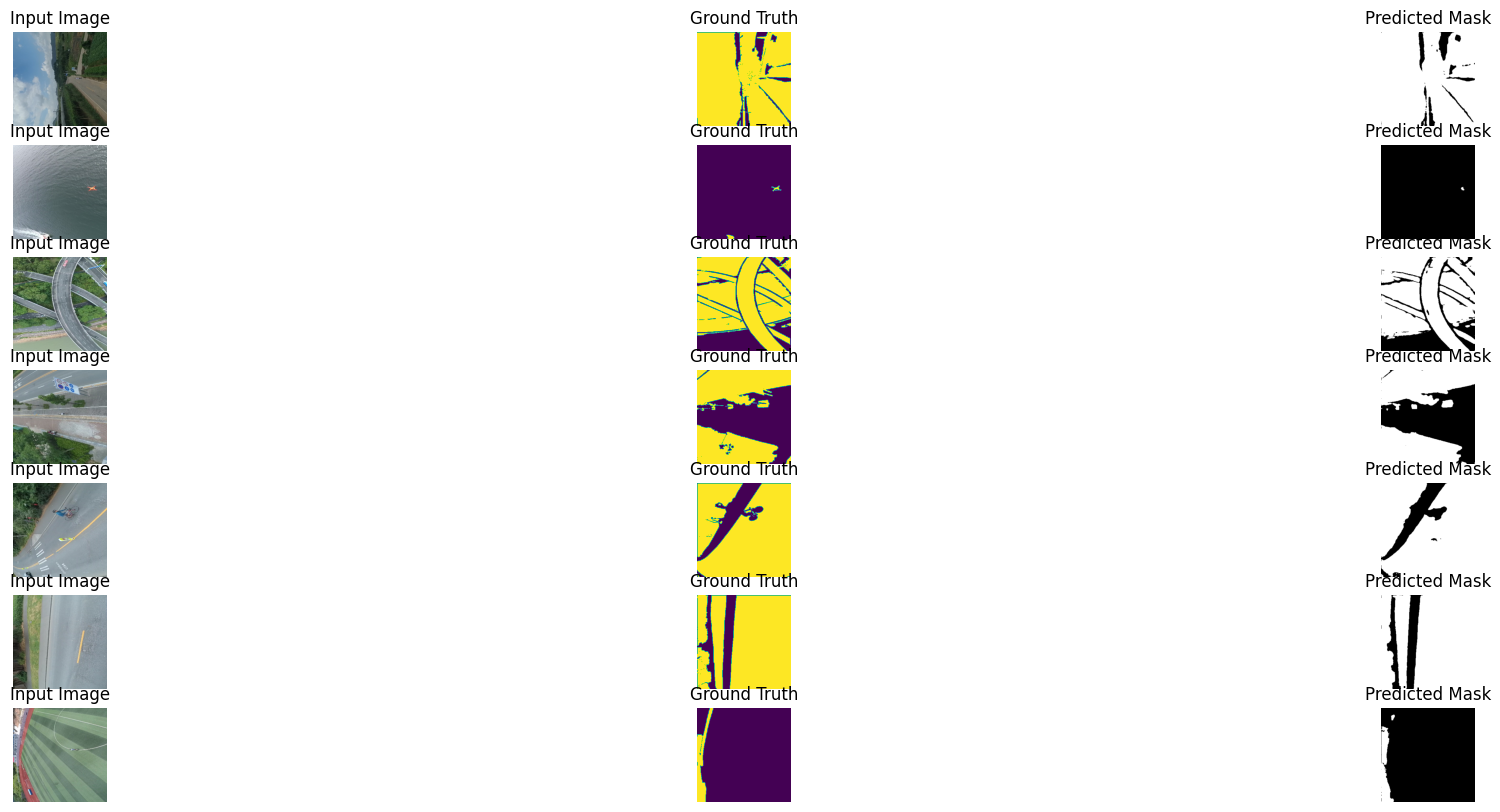

In [24]:
def inference(ds, model, device, n_ims=20):
    cols = 3
    rows = (n_ims + cols - 1) // cols
    count = 1

    images, gts, preds = [], [], []
    for idx, data in enumerate(ds):
        im, gt = data
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        images.append(im.cpu().numpy()) #.cpu()
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())

    plt.figure(figsize=(25, 10))
    while count <= n_ims:
        for idx, (im, gt, pred) in enumerate(zip(images, gts, preds)):

            if count > n_ims:
                break
            plt.subplot(rows, cols, count)

            plt.imshow(im.squeeze(0).transpose(2, 1, 0))
            plt.title("Input Image")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(gt.transpose(2, 1, 0))

            plt.title("Ground Truth")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(pred.transpose(2, 1, 0), cmap = 'gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            count += 1

    plt.show()

model = torch.load("save_aerospaces_best_model/aerospaces_best_model.pt")
inference(ts_dl, model=model, device=device)